# Data

In [1]:
%%shell
mkdir /root/.kaggle
mv ./kaggle.json /root/.kaggle/kaggle.json
chmod 600 /root/.kaggle/kaggle.json
kaggle competitions download -c mercari-price-suggestion-challenge
7za e train.tsv.7z
7za e test.tsv.7z

 62% 21.0M/34.0M [00:00<00:00, 46.3MB/s]
100% 34.0M/34.0M [00:00<00:00, 97.7MB/s]
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 55.5MB/s]
  0% 0.00/7.77M [00:00<?, ?B/s]
100% 7.77M/7.77M [00:00<00:00, 71.5MB/s]
 99% 292M/294M [00:02<00:00, 149MB/s]
100% 294M/294M [00:02<00:00, 145MB/s]
100% 74.0M/74.3M [00:00<00:00, 136MB/s]
100% 74.3M/74.3M [00:00<00:00, 150MB/s]

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 77912192 bytes (75 MiB)

Extracting archive: train.tsv.7z
--
Path = train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      3% - train.tsv                  7% - train.tsv                 11% - train.tsv

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math


from subprocess import check_output


In [3]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [4]:
# LOADING THE TRAIN AND TEST DATA
train = pd.read_table("train.tsv")
test = pd.read_table("test.tsv")
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (1482535, 8)
Test Shape: (693359, 7)


# EDA

In [5]:
!pip install pandas_summary

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pandas_profiling import ProfileReport
from IPython import display

from bokeh.io import output_notebook
from bokeh.models import HoverTool
from pandas_summary import DataFrameSummary
from bokeh.io import output_file, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.models.annotations import Title
%matplotlib inline

In [7]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [9]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [10]:
train.isnull().sum(axis=0)

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

### Item Price Analysis

In [11]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

[Text(0.5, 1.0, 'Price Distribution')]

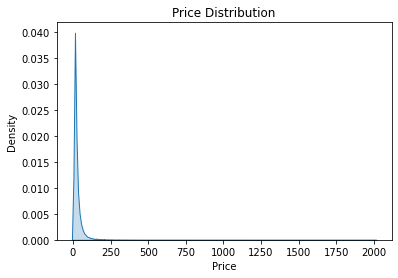

In [12]:
ax = sns.kdeplot(train.price, shade = True)
ax.set(xlabel='Price')
ax.set(title="Price Distribution")
# rightly skewed distribution not uniformly distributed

[Text(0.5, 1.0, 'log1p(Price) Distribution')]

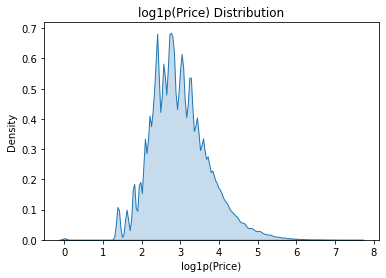

In [13]:
ax = sns.kdeplot(np.log1p(train.price), shade = True)
ax.set(xlabel='log1p(Price)')
ax.set(title="log1p(Price) Distribution")
# need a log distribution to have it uniformly distrubted, it is except right side

### Item Condition Analysis

In [14]:
item_condition_df = pd.DataFrame(train.item_condition_id.value_counts(normalize=True)*100)
item_condition_df

,item_condition_id
1,43.206332
3,29.150138
2,25.326822
4,2.155902
5,0.160806


[Text(0.5, 1.0, 'Products Condition')]

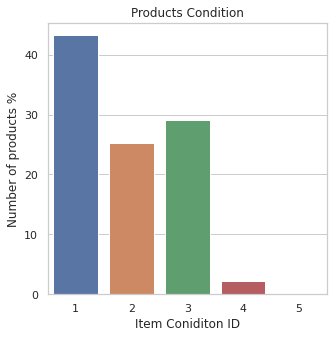

In [15]:
sns.set(style="whitegrid")
plt.subplots(figsize=(5,5))
plt.xlabel = "Item Condition"
plt.ylabel = ""
ax = sns.barplot(x=item_condition_df.index, y=item_condition_df.item_condition_id)
ax.set(xlabel='Item Coniditon ID', ylabel='Number of products %')
ax.set(title="Products Condition")

In [16]:
train.item_description[train.item_condition_id==1][:10]

2     Adorable top with a hint of lace and a key hol...
3     New with tags. Leather horses. Retail for [rm]...
4             Complete with certificate of authenticity
11    (5) new vs pink body mists (2.5 oz each) Fresh...
13                                   No description yet
15    Brand new. Deluxe travel size products. Contai...
16    2 glitter eyeshadows; one in Brass and one in ...
17    Brand new in box Size: Medium Color: Coral Ret...
18    This AUTHENTIC pallete by Too Faced is brand n...
21    NWT Victoria's Secret ULTIMATE SPORT BRA -MAXI...
Name: item_description, dtype: object

In [17]:
train.item_description[train.item_condition_id==5][:10]

258     Powers on, no screen display, no external dama...
653                                    No description yet
1027                 10k gold 18" chain. Broken at clasp.
2436    For parts . Turns on and hold battery charge ....
2803    2 pounds of junk jewelry, There are some items...
3177                                   No description yet
3394                                  For parts or repair
4948         moving out so just dont wanna keep For Free！
5055                      Powers on but won't play games.
5938    Alex and ani rafaelian gold set of four bracel...
Name: item_description, dtype: object

### Item Shipping Analysis

In [18]:
#shipping condition
shipping_df = pd.DataFrame(train.shipping.value_counts(normalize=True)*100)
shipping_df

,shipping
0,55.272557
1,44.727443


[Text(0.5, 1.0, 'Products Shipping')]

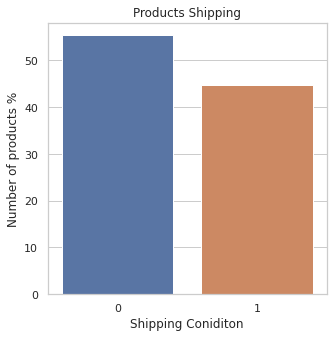

In [19]:
sns.set(style="whitegrid")
plt.subplots(figsize=(5,5))
ax = sns.barplot(x=shipping_df.index, y=shipping_df.shipping)
ax.set(xlabel='Shipping Coniditon', ylabel='Number of products %')
ax.set(title="Products Shipping")

In [20]:
# price analysis for different shipping conditions
train.groupby('shipping').price.mean()

shipping
0    30.111778
1    22.567726
Name: price, dtype: float64

In [21]:
seller_shipping= train.loc[train.shipping==1].price
not_seller_shipping = train.loc[train.shipping==0].price

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, 'log1p(Price) Distribution for different shipping conditions')]

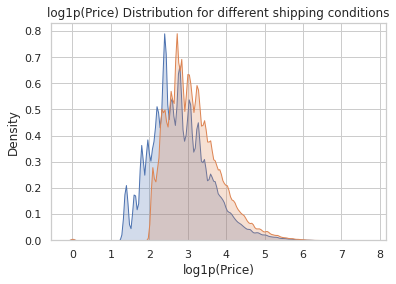

In [22]:
ax = sns.kdeplot(np.log1p(seller_shipping),label="shipping: 1",
                   shade=True, shade_lowest=False)
ax = sns.kdeplot(np.log1p(not_seller_shipping),label="shipping: 0",
                   shade=True, shade_lowest=False)
ax.set(xlabel='log1p(Price)')
ax.set(title="log1p(Price) Distribution for different shipping conditions")

In [23]:
train['log_prices']= np.log(train['price'].values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [24]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.302585
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.951244
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.302585
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.555348
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.784190


### Item Brand Name Analysis

In [25]:
train.brand_name.nunique()

4809

In [26]:
brand_names_list = list(train.brand_name.unique())
brand_names_list[:20]

[nan,
 'Razer',
 'Target',
 'Acacia Swimwear',
 'Soffe',
 'Nike',
 'Smashbox',
 "Victoria's Secret",
 'rue',
 'Scholastic',
 'UGG Australia',
 'Tarte',
 'Wet n Wild',
 'Too Faced',
 'Anthropologie',
 'Torrid',
 'Samsung',
 'FOREVER 21',
 'Air Jordan',
 'Apple']

In [63]:
#43% values contain NaNs, top most frequent brands from remaining 57% data are
train.brand_name.value_counts(normalize=True,dropna=True).nlargest(10)*100

PINK                 6.364395
Nike                 6.359100
Victoria's Secret    5.652272
LuLaRoe              3.650514
Apple                2.038235
FOREVER 21           1.786897
Nintendo             1.765835
Lululemon            1.713002
Michael Kors         1.638872
American Eagle       1.559564
Name: brand_name, dtype: float64

[Text(0.5, 1.0, 'Most Expensive Brands')]

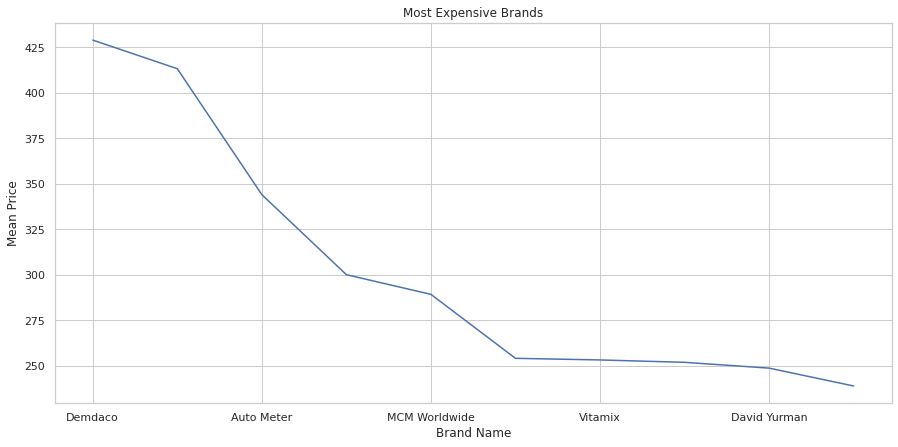

In [27]:
## most expensive brands
fig, ax = plt.subplots(figsize=(15,7))
train.groupby(['brand_name']).mean()['price'].nlargest(10).plot(ax=ax)
ax.set(xlabel='Brand Name', ylabel='Mean Price')
ax.set(title="Most Expensive Brands")

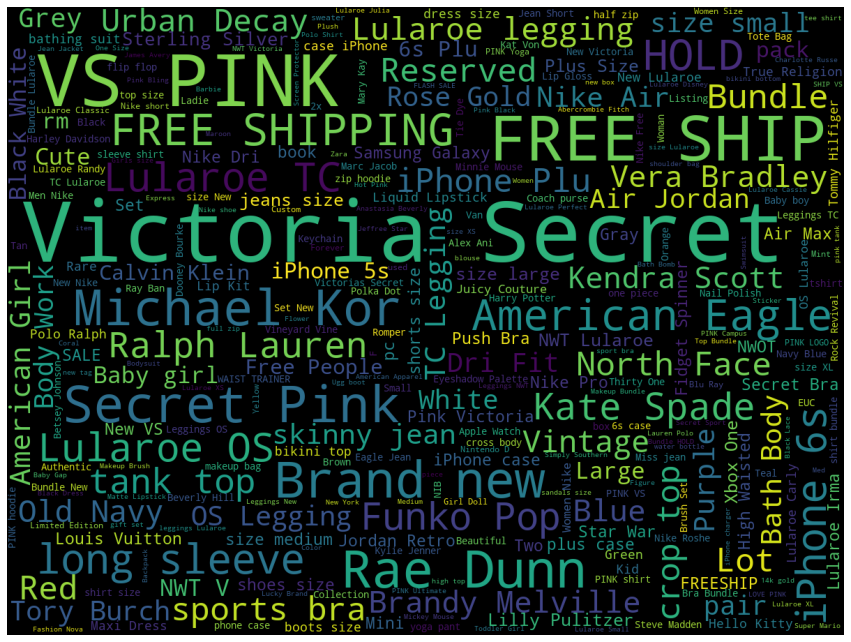

In [28]:
%matplotlib inline
from wordcloud import WordCloud

wc = WordCloud(max_words=300,width = 1200, height = 900).generate(" ".join(train['name'].astype(str)))
plt.figure(figsize = (15, 14))
plt.imshow(wc)
plt.axis("off")
plt.show()

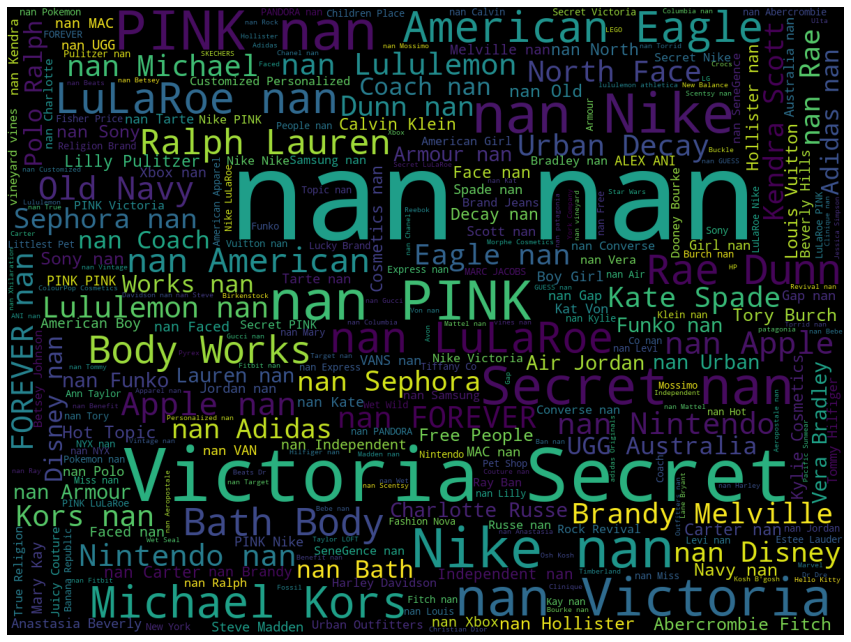

In [29]:
%matplotlib inline
from wordcloud import WordCloud

wc = WordCloud(max_words=300,width = 1200, height = 900).generate(" ".join(train['brand_name'].astype(str)))
plt.figure(figsize = (15, 14))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [30]:
train.brand_name.isnull().sum(axis=0)

632682

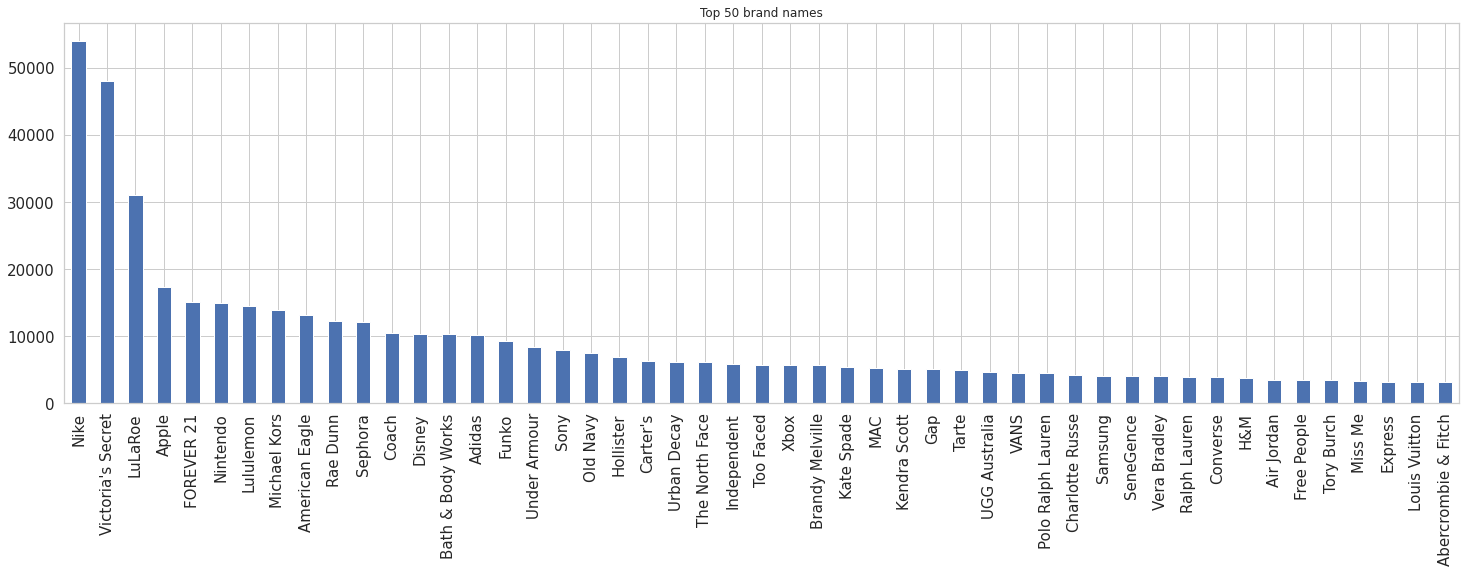

In [31]:
train['brand_name'].value_counts()[1:50].plot(kind='bar', figsize=(25,7), title="Top 50 brand names", fontsize=15)


### Item Category Analysis

In [32]:
def split_cat(text):
    """
    This function separated the categories into its three parts. Main category, sub-category 1 and sub-category 2
    """
    try: 
        return text.split("/")
    except: 
        return ("No Label", "No Label", "No Label")

train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.302585,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.951244,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.302585,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.555348,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.784190,Women,Jewelry,Necklaces


In [33]:
train['general_cat'].value_counts()


Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
No Label                    6327
Name: general_cat, dtype: int64

In [34]:
total_rows = train.shape[0]
general_cat_counts = train['general_cat'].value_counts()
print("Women=\t", round(general_cat_counts['Women']/total_rows*100,2),'%')
print("Beauty\t", round(general_cat_counts['Beauty']/total_rows*100,2),'%')
print("Kids=\t", round(general_cat_counts['Kids']/total_rows*100,4),'%')
print("Electronics=\t", round(general_cat_counts['Electronics']/total_rows*100,4),'%')
print("Men=\t", round(general_cat_counts['Men']/total_rows*100,4),'%')
print("Home=\t", round(general_cat_counts['Home']/total_rows*100,4),'%')
print("Vintage & Collectibles=\t", round(general_cat_counts['Vintage & Collectibles']/total_rows*100,4),'%')
print("Other=\t", round(general_cat_counts['Other']/total_rows*100,4),'%')
print("Handmade=", round(general_cat_counts['Handmade']/total_rows*100,4),'%')
print("Sports & Outdoors=\t", round(general_cat_counts['Sports & Outdoors']/total_rows*100,4),'%')
print("No Label=", round(general_cat_counts['No Label']/total_rows*100,4),'%')

Women=	 44.81 %
Beauty	 14.02 %
Kids=	 11.5808 %
Electronics=	 8.2757 %
Men=	 6.3189 %
Home=	 4.578 %
Vintage & Collectibles=	 3.1385 %
Other=	 3.059 %
Handmade= 2.0804 %
Sports & Outdoors=	 1.7094 %
No Label= 0.4268 %


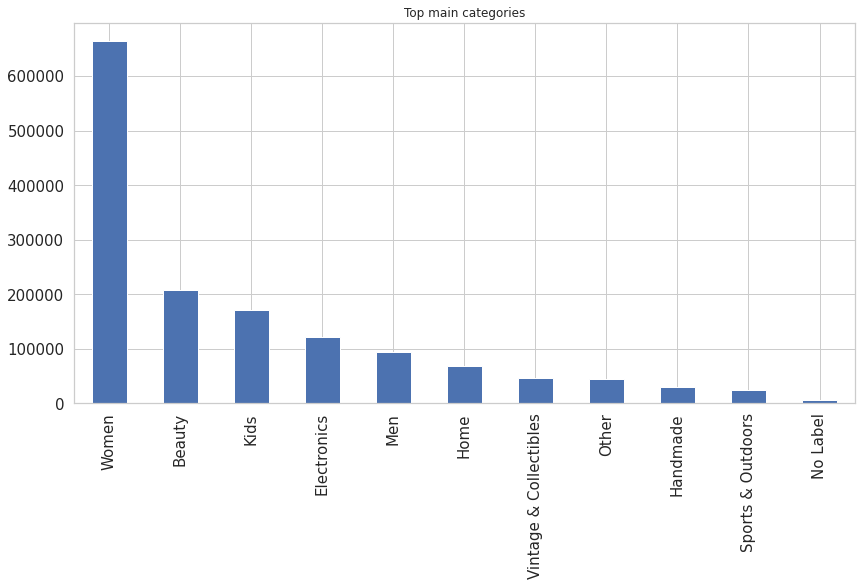

In [35]:
train['general_cat'].value_counts().plot(kind='bar', figsize=(14,7), title="Top main categories", fontsize=15)


In [36]:
train.category_name.nunique()

1287

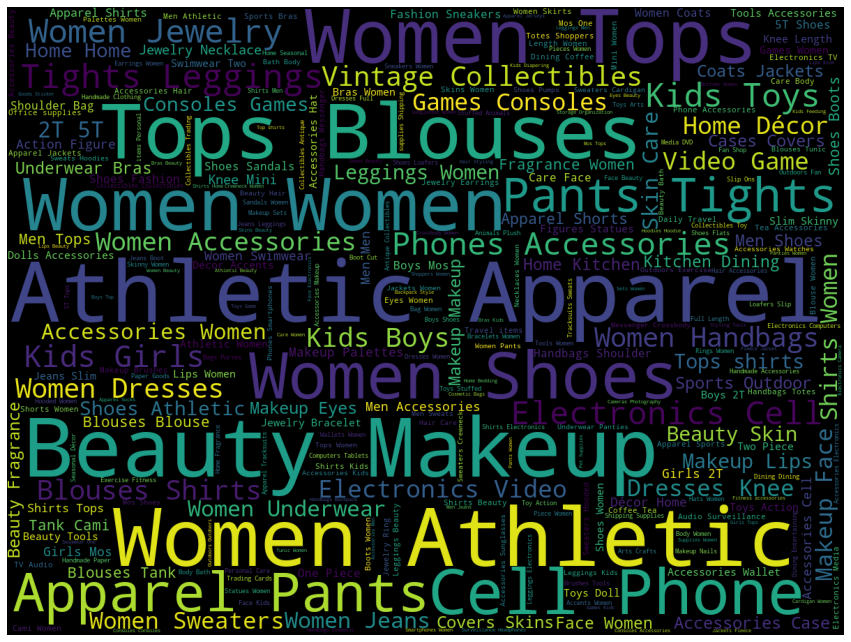

In [37]:
wc = WordCloud(max_words=300,width = 1200, height = 900).generate(" ".join(train['category_name'].astype(str)))
plt.figure(figsize = (15, 14))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [38]:
train.groupby(train.category_name.str.count("/")).count()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
category_name,,,,,,,,,,,,
2.0,1471819,1471819,1471819,1471819,844461,1471819,1471819,1471815,1471819,1471819,1471819,1471819
3.0,1330,1330,1330,1330,372,1330,1330,1330,1330,1330,1330,1330
4.0,3059,3059,3059,3059,2150,3059,3059,3059,3059,3059,3059,3059


In [39]:
free_products = train[train.price==0]
free_products.shape[0]

874

# Data Preprocessing

In [40]:
# HANDLING THE MISSING VALUES FOR TRAINING AND TESTING DATA BY REPLACING VALUES WITH Other_Null
def handle_missing(dataset):
    dataset.category_name.fillna(value="Other_Null", inplace=True)
    dataset.brand_name.fillna(value="Other_Null", inplace=True)
    dataset.item_description.fillna(value="Other_Null", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)


In [41]:
# PROCESSING THE CATEGORICAL DATA USING THE LABEL ENCODER
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,3487,10.0,1,No description yet,2.302585,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,86,3890,52.0,0,This keyboard is in great condition and works ...,3.951244,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,1278,4589,10.0,1,Adorable top with a hint of lace and a key hol...,2.302585,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,503,3487,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.555348,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,1205,3487,44.0,0,Complete with certificate of authenticity,3.784190,Women,Jewelry,Necklaces


In [42]:
# PROCCESSING THE TEXT USING TOKENIZER
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

# Creates the vocabulary index based on the word frequency using the raw text
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

# Transforms the training and testing item_descriptions and names to a sequence of integers
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())

train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,3487,10.0,1,No description yet,2.302585,Men,Tops,T-shirts,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3890,52.0,0,This keyboard is in great condition and works ...,3.951244,Electronics,Computers & Tablets,Components & Parts,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1278,4589,10.0,1,Adorable top with a hint of lace and a key hol...,2.302585,Women,Tops & Blouses,Blouse,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"
3,3,Leather Horse Statues,1,503,3487,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.555348,Home,Home Décor,Home Décor Accents,"[5, 9, 61, 178, 6528, 230, 3, 21, 166, 1085, 2...","[178, 2610, 14248]"
4,4,24K GOLD plated rose,1,1205,3487,44.0,0,Complete with certificate of authenticity,3.784190,Women,Jewelry,Necklaces,"[807, 9, 6888, 11, 1997]","[4884, 104, 1032, 280]"


In [43]:
# ANALYZING THE SEQUENCE VARIABLES ITEM NAME AND ITEM DESCRIPTION
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("Maximum Name Sequence: "+str(max_name_seq))
print("Maximum Item Description: "+str(max_seq_item_description))

Maximum Name Sequence: 17
Maximum Item Description: 269


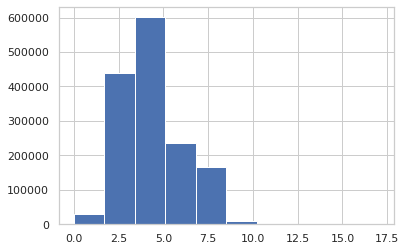

In [46]:
### Sequence name frequency vs. length 
train.seq_name.apply(lambda x: len(x)).hist()


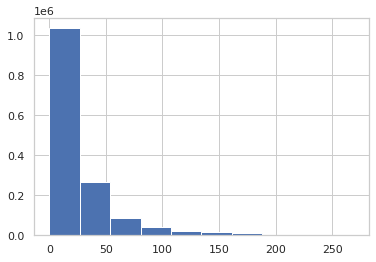

In [47]:
### Sequence item description vs. length 
train.seq_item_description.apply(lambda x: len(x)).hist()


In [48]:
# EMBEDDINGING THE MAX VALUE
# Based on the histogram plots the next lengths are selected
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfb224c910>]],
      dtype=object)

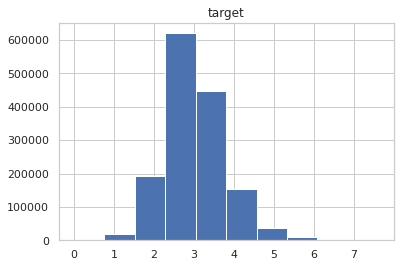

In [49]:
# SCALING THE TAREGT VARIABLE (PRICE) USING MINMAXSCALER TO THE RANGE OF -1 AND 1
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
pd.DataFrame(train.target).hist()

In [50]:
# USING TRAIN TEST SPLIT IN ORDER TO GET OUR TRAIN AND VALIDATION DATA FROM THE TRAINING DATA
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print("Train Set Shape:", dtrain.shape)
print("Validation Set Shape:", dvalid.shape)

Train Set Shape: (1467709, 15)
Validation Set Shape: (14826, 15)


In [51]:
# FUNCTION TO GET KERAS DATA
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'category_name': np.array(dataset.category_name)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

# Models and Results

### Recurrent Neural Network (RNN)

In [46]:
# CREATING THE NECESSARY FUNCTIONS FOR THE RNN MODEL
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, Conv1D, GlobalMaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_rnn_model():
    # Parameters
    dr_r = 0.1
    
    # Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    # Embedding layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    # RNN layers
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    # Main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    # Output layer
    output = Dense(1, activation="linear") (main_l)
    
    # RNN Model Itself
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_rnn_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 category_name (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 item_condition (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                              

In [47]:
# FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_rnn_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Epoch 1/5
74/74 [==============================] - 26s 241ms/step - loss: 1.8178 - mae: 0.9839 - rmsle_cust: 0.3027 - val_loss: 0.3259 - val_mae: 0.4345 - val_rmsle_cust: 0.1101
Epoch 2/5
74/74 [==============================] - 17s 230ms/step - loss: 0.3167 - mae: 0.4298 - rmsle_cust: 0.1089 - val_loss: 0.2616 - val_mae: 0.3874 - val_rmsle_cust: 0.0985
Epoch 3/5
74/74 [==============================] - 17s 231ms/step - loss: 0.2767 - mae: 0.4000 - rmsle_cust: 0.1015 - val_loss: 0.2446 - val_mae: 0.3735 - val_rmsle_cust: 0.0951
Epoch 4/5
74/74 [==============================] - 17s 232ms/step - loss: 0.2569 - mae: 0.3847 - rmsle_cust: 0.0977 - val_loss: 0.2371 - val_mae: 0.3675 - val_rmsle_cust: 0.0936
Epoch 5/5
74/74 [==============================] - 17s 230ms/step - loss: 0.2434 - mae: 0.3738 - rmsle_cust: 0.0950 - val_loss: 0.2342 - val_mae: 0.3654 - val_rmsle_cust: 0.0931


In [48]:
# EVALUATING THE RNN MODEL ON VALIDATION
def eval_model(model):
    val_preds = model.predict(X_valid)
    val_preds = np.exp(val_preds)+1

    y_true = np.array(dvalid.price.values)
    y_pred = val_preds[:,0]
    v_rmsle = rmsle(y_true, y_pred)
    print(" RMSLE error on validation set: "+str(v_rmsle))

eval_model(model)

 RMSLE error on validation set: 0.4968936432551526


### Convolutionary Neural Network (CNN)

In [49]:
def get_cnn_model():  
    # Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    # Embedding layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    # CNN layers
    convs1 = []
    convs2 = []
    
    for filter_length in [1,2]:
        cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (emb_name)
        cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (emb_item_desc)
        
        maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
        maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
        
        convs1.append(maxpool1)
        convs2.append(maxpool2)

    convs1 = concatenate(convs1)
    convs2 = concatenate(convs2)
    
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , convs1
        , convs2
        , num_vars
    ])

    # Main layer
    main_l = Dropout(0.25)(Dense(128, activation='relu') (main_l)) 
    main_l = Dropout(0.1)(Dense(64, activation='relu') (main_l)) 

    # Output layer    
    output = Dense(1, activation='linear') (main_l)

     # CNN Model Itself
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss='mse', optimizer='adam', metrics=["mae", rmsle_cust])
    
    return model

model = get_cnn_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 name (InputLayer)              [(None, 10)]         0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 10, 50)       12954400    ['name[0][0]']                   
                                                                                                  
 embedding_11 (Embedding)       (None, 75, 50)       12954400    ['item_desc[0][0]']              
                                                                                            

In [50]:
# FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_rnn_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Epoch 1/5
74/74 [==============================] - 23s 244ms/step - loss: 1.8458 - mae: 1.0015 - rmsle_cust: 0.3054 - val_loss: 0.3196 - val_mae: 0.4340 - val_rmsle_cust: 0.1099
Epoch 2/5
74/74 [==============================] - 17s 232ms/step - loss: 0.3208 - mae: 0.4327 - rmsle_cust: 0.1097 - val_loss: 0.2584 - val_mae: 0.3847 - val_rmsle_cust: 0.0978
Epoch 3/5
74/74 [==============================] - 17s 231ms/step - loss: 0.2780 - mae: 0.4012 - rmsle_cust: 0.1019 - val_loss: 0.2415 - val_mae: 0.3706 - val_rmsle_cust: 0.0943
Epoch 4/5
74/74 [==============================] - 17s 230ms/step - loss: 0.2560 - mae: 0.3842 - rmsle_cust: 0.0976 - val_loss: 0.2349 - val_mae: 0.3660 - val_rmsle_cust: 0.0932
Epoch 5/5
74/74 [==============================] - 17s 231ms/step - loss: 0.2409 - mae: 0.3722 - rmsle_cust: 0.0946 - val_loss: 0.2322 - val_mae: 0.3642 - val_rmsle_cust: 0.0928


In [51]:
eval_model(model)

 RMSLE error on validation set: 0.4912897460817548


# Conclusion

Using both RNN and CNN, it becomes evident that the CNN model performs better with a RMSLE lower than that of the RNN model.  However, the CNN model's RMSLE error is only slightly smaller than that of the RNN model.